In [8]:
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from neo4j import GraphDatabase
from neo4_connection import USER, PWD, URL 

from sklearn import model_selection, metrics, preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from umap import UMAP

import torch
import torch.nn as nn
from torch.nn import Linear, MSELoss
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv, to_hetero, MetaPath2Vec
from torch_geometric.transforms import RandomLinkSplit, ToUndirected, AddSelfLoops, NormalizeFeatures

In [7]:
user_df = pd.read_csv('./datasets/ml100k_users.csv')
movie_df = pd.read_csv('./datasets/ml100k_movies.csv')
actor_df = pd.read_csv('./datasets/ml100k_actors.csv')
director_df = pd.read_csv('./datasets/ml100k_directors.csv')
genre_df = pd.read_csv('./datasets/ml100k_genres.csv')

print(f'user_df: {user_df.shape}\nmovie_df: {movie_df.shape}\nactor_df: {actor_df.shape}\n' \
    f'director_df: {director_df.shape}\ngenre_df: {genre_df.shape}')

user_df: (671, 1)
movie_df: (9125, 1)
actor_df: (15443, 1)
director_df: (4091, 1)
genre_df: (20, 1)


In [12]:
user_movie_df = pd.read_csv('./datasets/ml100k_user-movie.csv')
movie_actor_df = pd.read_csv('./datasets/ml100k_movie-actor.csv')
movie_director_df = pd.read_csv('./datasets/ml100k_movie-director.csv')
movie_genre_df = pd.read_csv('./datasets/ml100k_movie-genre.csv')

print(f'user_movie_df: {user_movie_df.shape}\nmovie_actor_df: {movie_actor_df.shape}\n' \
    f'movie_director_df: {movie_director_df.shape}\nmovie_genre_df: {movie_genre_df.shape}')

user_movie_df: (100004, 3)
movie_actor_df: (35910, 2)
movie_director_df: (10007, 2)
movie_genre_df: (20340, 2)


In [13]:
# Nodes
assert len(user_df) == 671, f'{user_df} length not as expected!'
assert len(movie_df) == 9125, f'{movie_df} length not as expected!'
assert len(actor_df) == 15443, f'{actor_df} length not as expected!'
assert len(director_df) == 4091, f'{director_df} length not as expected!'
assert len(genre_df) == 20, f'{genre_df} length not as expected!'

# Relations
assert len(user_movie_df) == 100004, f'{user_movie_df} length not as expected!'
assert len(movie_actor_df) == 35910, f'{movie_actor_df} length not as expected!'
assert len(movie_director_df) == 10007, f'{movie_director_df} length not as expected!'
assert len(movie_genre_df) == 20340, f'{movie_genre_df} length not as expected!'
# assert len(user_liked_movie_df) == 51568, f'{user_liked_movie_df} length not as expected!'


In [14]:
N_USERS, N_MOVIES, N_ACTORS, N_DIRECTORS, N_GENRES = len(user_df), len(movie_df), len(actor_df), len(director_df), len(genre_df)

print(f'N_USERS: {N_USERS}\nN_MOVIES: {N_MOVIES}\nN_ACTORS: {N_ACTORS}\nN_DIRECTORS: {N_DIRECTORS}\nN_GENRES: {N_GENRES}')

N_USERS: 671
N_MOVIES: 9125
N_ACTORS: 15443
N_DIRECTORS: 4091
N_GENRES: 20


### Create Pytorch Geometric (heterogenious) Dataset

In [23]:
x_movies = np.load('./datasets/20221118_np_movie_array.npy')
x_movies.shape

(9125, 24)

In [24]:
x_users = np.eye(N_USERS, N_USERS)
x_actors = np.eye(N_ACTORS, N_ACTORS)
x_directors = np.eye(N_DIRECTORS, N_DIRECTORS)
x_genres = np.eye(N_GENRES, N_GENRES)

print(f'x_users: {x_users.shape}\nx_actors: {x_actors.shape}\n' \
    f'x_directors: {x_directors.shape}\nx_genres: {x_genres.shape}')

x_users: (671, 671)
x_actors: (15443, 15443)
x_directors: (4091, 4091)
x_genres: (20, 20)


### Create PyG dataset with node embeddings 

In [25]:
data = HeteroData()

# nodes
data['user'].x = x_users
data['movie'].x = x_movies
data['actor'].x = x_actors
data['director'].x = x_directors
# data['genre'].x = x_genres

# edge indecies
data[('user', 'rated', 'movie')].edge_index = edge_index_user_rated_movie
data[('actor', 'played_in', 'movie')].edge_index = edge_index_actor_playedIn_movie
# data[('director', 'directed', 'movie')].edge_index = edge_index_director_directed_movie
data[('movie', 'in', 'genre')].edge_index = edge_index_movie_in_genre

# edge labels
data[('user', 'rated', 'movie')].edge_label = edge_label_user_rated_movie

# add reverse edges
data = ToUndirected()(data)
del data[('movie', 'rev_rated', 'user')].edge_label

data

NameError: name 'edge_index_user_rated_movie' is not defined

### Train/Test Split

In [ ]:
# Perform a link-level split into training, validation, and test edges.
train_data, val_data, test_data = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rated', 'movie')],
    rev_edge_types=[('movie', 'rev_rated', 'user')],
)(data)

### Define the model

In [ ]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        # these convolutions have been replicated to match the number of edge types
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin_out = Linear(hidden_channels, 1)
        
    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        # concat user and movie embeddings
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)
        # concatenated embeddings passed to linear layer
        z = self.lin1(z).relu()
        z = self.lin_out(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        # z_dict contains dictionary of movie and user embeddings returned from GraphSage
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)


model = Model(hidden_channels=64).to(device)

In [ ]:
# Due to lazy initialization, we need to run one model step so the number
# of parameters can be inferred:
with torch.no_grad():
    model.encoder(train_data.x_dict, train_data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters())

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['user', 'movie'].edge_label_index)
    target = train_data['user', 'movie'].edge_label
    # loss = weighted_mse_loss(pred, target, weight)
    loss = F.mse_loss(pred, target).sqrt()
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'movie'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

In [ ]:
EPOCHS = 600
train_losses, val_losses, test_losses = [], [], []
for epoch in range(1, EPOCHS+1):
    train_loss = train()
    # train_rmse = test(train_data)
    val_rmse = test(val_data)
    test_rmse = test(test_data)
    
    train_losses.append(train_loss), val_losses.append(val_rmse), test_losses.append(test_rmse)
    
    print(f'Epoch: {epoch:03d}\tTrain: {train_loss:.4f}\t'
          f'Val: {val_rmse:.4f}\tTest: {test_rmse:.4f}')
    # break

Epoch: 001	Train: 3.6656	Val: 3.4181	Test: 3.4180
Epoch: 002	Train: 3.4226	Val: 3.1644	Test: 3.1645
Epoch: 003	Train: 3.1679	Val: 2.8937	Test: 2.8941
Epoch: 004	Train: 2.8963	Val: 2.6046	Test: 2.6050
Epoch: 005	Train: 2.6061	Val: 2.2952	Test: 2.2954
Epoch: 006	Train: 2.2955	Val: 1.9678	Test: 1.9674
Epoch: 007	Train: 1.9668	Val: 1.6352	Test: 1.6332
Epoch: 008	Train: 1.6327	Val: 1.3354	Test: 1.3303
Epoch: 009	Train: 1.3315	Val: 1.1590	Test: 1.1491
Epoch: 010	Train: 1.1576	Val: 1.1988	Test: 1.1867
Epoch: 011	Train: 1.2215	Val: 1.3392	Test: 1.3269
Epoch: 012	Train: 1.4165	Val: 1.4221	Test: 1.4097
Epoch: 013	Train: 1.5433	Val: 1.4302	Test: 1.4180
Epoch: 014	Train: 1.5520	Val: 1.3808	Test: 1.3686
Epoch: 015	Train: 1.4697	Val: 1.2939	Test: 1.2818
Epoch: 016	Train: 1.3422	Val: 1.1999	Test: 1.1875
Epoch: 017	Train: 1.2184	Val: 1.1370	Test: 1.1246
Epoch: 018	Train: 1.1406	Val: 1.1283	Test: 1.1178
Epoch: 019	Train: 1.1270	Val: 1.1635	Test: 1.1551
Epoch: 020	Train: 1.1608	Val: 1.2118	Test: 1.2048


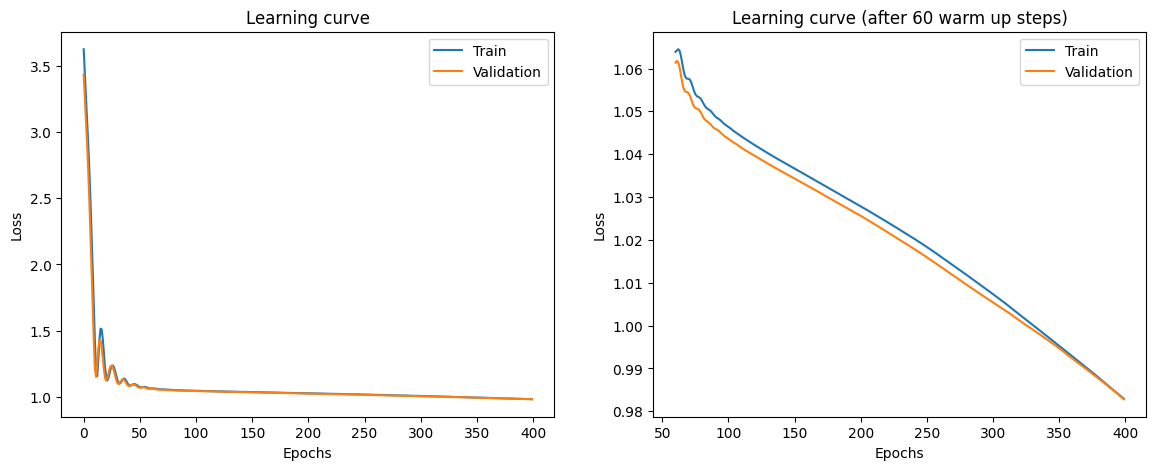

In [ ]:
SKIP_WARM_UP_STEPS = 60

_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
ax0.plot(train_losses, label='Train')
ax0.plot(val_losses, label='Validation')
ax0.set_title('Learning curve')
ax0.set_xlabel('Epochs')
ax0.set_ylabel('Loss')
ax0.legend()

ax1.plot(range(SKIP_WARM_UP_STEPS, len(train_losses)), train_losses[SKIP_WARM_UP_STEPS:], label='Train')
ax1.plot(range(SKIP_WARM_UP_STEPS, len(train_losses)), val_losses[SKIP_WARM_UP_STEPS:], label='Validation')
ax1.set_title(f'Learning curve (after {SKIP_WARM_UP_STEPS} warm up steps)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
plt.show()